> # LSDM
> ## Assignment 2: Analyzing Co-movement in Music Sentiment and Policy Uncertainty
> Elena Badillo Goicoechea

> Oct 26, 2018

In [1]:
import multiprocessing as mp
import pandas as pd
import sys
sys.path.insert(0, '/Users/elenabg/Documents/4Q/LSDA/HW/hw2/')
import lyric_sentiment as lysent
%load_ext autoreload
%autoreload 2

## 1. Introduction

In this assignment, we aim to extract music lyrics from all  publicly available songs from 1995 to 2018, compute each song's sentiment using CoreNLP built-in software, and compare the __evolution of average annual music sentiment to the evolution of average annual policy uncertainty__ in the US. 

The prior is that __higher policy uncertainty__ is associated to __more negative lyric sentiment__ (the higher the sentiment score, the higher the "positiveness". Policy uncertainty is calculated monthly using news and economic indicators as components.

We compute music sentiment as a weighted sentiment score using the probability that a given lyric is classified as Very Negative (=1), Negative (=2), Neutral (=3), Positive (=4), and Very Positive (=5). The Stanford NLP sentiment analysis toolkit outputs a sentiment probability distribution that we use to weight the integer scores into one overall score, which we then average on an annual basis.

### 2. Data

- Data: Music lyrics and economic + political ("policy") uncertainty index

    - Text stream of song lyrics + song metadata (artist, title, album, year) from 1995 to 2018
    - Monthly US policy uncertainty index from 1995 to 2018
    
- Data Sources:

    - Music Lyrics (Lyrics Wiki), a comprehensive music lyric website:
        - http://lyrics.wikia.com/wiki/Category:Albums_by_Release_Year
    - US Policy Uncertainty Index (EPU), computed monthly for US and other countries by [Baker, Davis, and Bloom](http://www.policyuncertainty.com/about.html):
        http://www.policyuncertainty.com/us_monthly.html

- Data Analysis:

    - Compute, via NLP, mean annual music sentiment.
    - Showing evolution of music lyric sentiment on time.
    - Looking at co-movement of sentiment and political uncertainty indexes over time
        
- Parallelization Strategy:

    - Divide into even, only mod(5) and neither, years for scraping lyrics, using a shared list among tree producer processes and a consumer process sharing a queue and other appropriate data structures.

## 2. Load Data

### Parallel Lyrics Scraping and Sentiment Analysis with CoreNLP

First, we set up all the instances we'll use:

In [2]:
ec2_url='http://ec2-18-222-118-57.us-east-2.compute.amazonaws.com:9000' # Ubuntu @ AWS EC2 instance
nlp = lysent.connect_nlp(ec2_url) # our nlp connection via our EC2 instance

manager = mp.Manager()
queue = mp.Queue()
lyr_lst = manager.list()
sent_dict_lst = manager.list()

Then we run a script (attached) where:
- Three concurrent producer processes scrape all music lyrics and puts them in a queue (for brevity, we limit ourselves to artists whose name starts with A or B (otherwise, there would be tens of thousands of songs per year, out of scope here). Still, we get (excluding non-English and pure instrumental music) about a thousand songs per year.

- A consumer process empties the queue and gets music sentiments from CoreNLP for each lyrics, and the average for each year:

In [ ]:
lysent.process_lyrics(1994, lyr_lst, queue, nlp, sent_dict_lst)

In [4]:
sent_dict_lst # our manager-list containing a dictinary with the final output we need

<ListProxy object, typeid 'list' at 0x110843a58>

In [5]:
sent_dict = sent_dict_lst[0]

Each key in the dictionary we have generated is a year from 1995 to 2018, whose value is a dictionary with 1) a list of all qualified song's sentiment, 2) a float with average annual music sentiment:

In [6]:
sent_dict.keys() 

dict_keys(['1995', '2005', '2015', '1997', '1999', '2001', '1996', '2003', '1998', '2007', '2000', '2009', '2002', '2011', '2004', '2013', '2006', '2017', '2008', '2010', '2012', '2014', '2016', '2018'])

In [63]:
sent_dict['2018'] # Example, 2018

{'all_sents': [1.57501617639617,
  2.15207118348714,
  1.96491934460303,
  2.2048938910247604,
  1.4495574571181098,
  1.5197540890865,
  1.9841574038166199,
  2.22238338994847,
  2.5371777716669195,
  1.77294511535187,
  1.7910899147441302,
  2.00570199356234,
  2.25428409397229,
  1.81872888917159,
  1.9436074491171802,
  1.8702385465780702,
  1.93553762926484,
  4.11406054654465,
  1.72921681197843,
  2.0886495571808297,
  2.35497109586889,
  2.0430501453632197,
  1.8325208391181298,
  1.8556491655018001,
  1.86325338894584,
  1.86349993399789,
  1.96956418991844,
  1.9990162452999,
  2.3375851807102,
  2.48309285118471,
  1.88874340671879,
  2.7726018072696,
  2.1565160186886803,
  2.0024111846591497,
  2.0564490029970197,
  1.68386651465636,
  2.0313442802332498,
  1.9599148106286397,
  2.0935225074327297,
  2.02560333267022,
  1.9528495759978404,
  2.1335544445042,
  2.02306183066909,
  1.9489775352029302,
  2.16996989597472,
  2.11545799861598,
  1.4882789547740098,
  2.18371296

### US Policy Uncertainty Index (EPU)

Now we load monthly EPU, from a csv downloaded from source website, and compute the annual average index from 1985 to 2018:

In [32]:
df = pd.read_csv("EPU_95.csv")
df = df[['Year', 'Baseline_overall_index']]
df_y = df.groupby('Year').aggregate({'Baseline_overall_index': 'mean'})
EPU_2002= df_y['Baseline_overall_index'].loc[2000]
df_y['EPU_norm'] = df_y['Baseline_overall_index'].apply(lambda x: x/EPU_2002) # normalize at 2002

## 4. Analyze Trends

Finally, we can analyze the average trends in time for both the lyrics sentiment and the policy uncertainty indeces:

In [33]:
av_sent_dict = {k:v['avg_sent'] for k,v in sent_dict.items()}

In [34]:
av_sent_dict

{'1995': 2.0350310433568892,
 '2005': 2.003434522817389,
 '2015': 2.047430627728778,
 '1997': 1.9970455166295915,
 '1999': 1.960483555007098,
 '2001': 2.0310624005972624,
 '1996': 2.0105932740119523,
 '2003': 1.9599310362017475,
 '1998': 1.9719855022808253,
 '2007': 2.046364976471749,
 '2000': 2.0373788422696655,
 '2009': 1.984866412468102,
 '2002': 2.062526137386959,
 '2011': 2.0316130322533894,
 '2004': 1.9966149475245647,
 '2013': 2.0259949112169084,
 '2006': 1.9885333025905,
 '2017': 2.0054998177276957,
 '2008': 1.9888510341584704,
 '2010': 1.9751030311493187,
 '2012': 2.0413642540362757,
 '2014': 2.0332593085609956,
 '2016': 1.9808171557178884,
 '2018': 2.0382207492212254}

In [55]:
df_y

,Baseline_overall_index,EPU_norm,lyr_sent,lyr_sent_norm,lyr_chg,EPU_chg
Year,,,,,,
1995,81.106289,0.920329,2.035031,0.998848,0.000000,0.000000
1996,75.214324,0.853472,2.010593,0.986853,-0.120085,-0.072645
1997,76.227345,0.864967,1.997046,0.980203,-0.067382,0.013468
1998,90.947533,1.032000,1.971986,0.967903,-0.125485,0.193109
1999,75.202428,0.853337,1.960484,0.962258,-0.058327,-0.173123
2000,88.127471,1.000000,2.037379,1.000000,0.392226,0.171870
2001,120.274133,1.364775,2.031062,0.996900,-0.031003,0.364775
2002,105.342409,1.195341,2.062526,1.012343,0.154913,-0.124147
2003,110.125642,1.249618,1.959931,0.961987,-0.497424,0.045407


In [47]:
df_y['lyr_chg'] = df_y['lyr_sent']
df_y['EPU_chg'] = df_y['lyr_sent']
for i in range(len(df_y)-1):
    df_y['lyr_chg'].iloc[i+1] = (df_y['lyr_sent'].iloc[i+1]-df_y['lyr_sent'].iloc[i])*10/df_y['lyr_sent'].iloc[i]
    df_y['EPU_chg'].iloc[i+1] = (df_y['Baseline_overall_index'].iloc[i+1]-\
                                 df_y['Baseline_overall_index'].iloc[i])/df_y['Baseline_overall_index'].iloc[i]


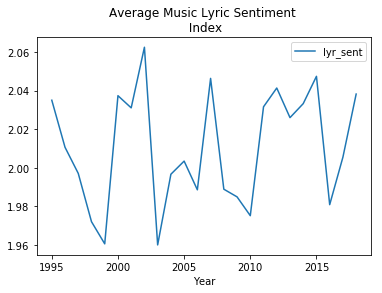

In [72]:
df_y['lyr_sent'].plot(title ='Average Music Lyric Sentiment \n Index', legend=True)

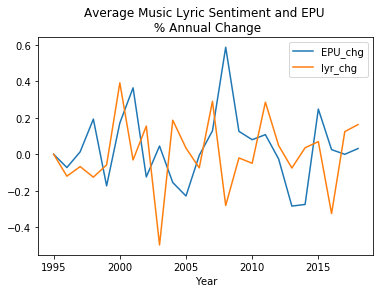

In [68]:
df_y['EPU_chg'].iloc[0]=0.0
df_y['lyr_chg'].iloc[0]=0.0
df_y[['EPU_chg', 'lyr_chg']].plot(legend=True, title ='Average Music Lyric Sentiment and EPU \n % Annual Change')

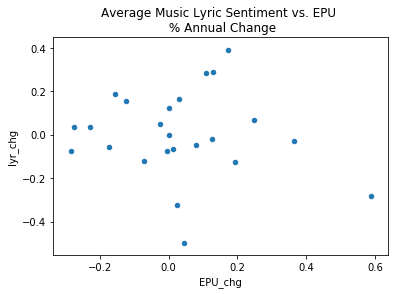

In [70]:
df_y.plot.scatter('EPU_chg', 'lyr_chg', legend=True, title ='Average Music Lyric Sentiment vs. EPU \n % Annual Change')

__Conclusion__: As the two last plots above show, we can see an inverse co-movement! It would be interesting (and fun) to look at the full sample of songs, i.e. artists from A to Z, and maybe look at other statistics.